# Classification

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [19]:
d = load_wine()
sum(d.target==2)

48

In [20]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['class'] = d.target
df = df[df['class'].isin({0,1})]
df.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [21]:
df = df[['proline','alcohol','class']]
df.head(3)

,proline,alcohol,class
0,1065.0,14.23,0
1,1050.0,13.20,0
2,1185.0,13.16,0


In [22]:
def show(df, normalize=False):
    if normalize:
        df = df.copy()
        df.proline = (df.proline-np.mean(df.proline))/np.std(df.proline)
        df.alcohol = (df.alcohol-np.mean(df.alcohol))/np.std(df.alcohol)
        
    fig, ax = plt.subplots(figsize=(4,3))
    df0 = df[df['class']==0]
    df1 = df[df['class']==1]
    ax.scatter(df0.proline, df0.alcohol, marker='x', s=45, color='#F46C43', alpha=1, label='class 0')
    ax.scatter(df1.proline, df1.alcohol, marker='o', s=45, color='#4574B4', alpha=.7, label='class 1')
    ax.set_xlabel("proline")
    ax.set_ylabel("alcohol")
    ax.set_title("Wine classification")
    plt.legend(loc='lower right')
    plt.show()

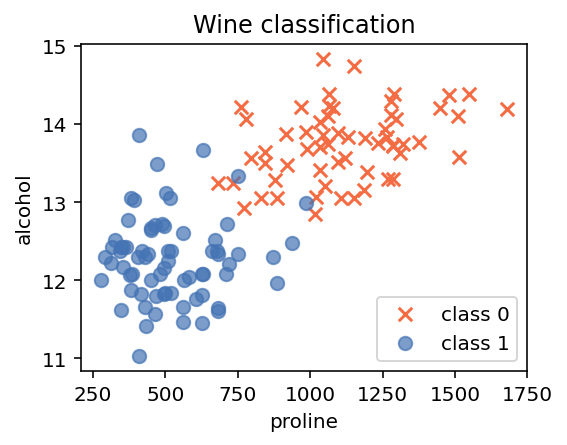

In [23]:
show(df)

In [281]:
def ctrain(model, X, y, learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = F.binary_cross_entropy(y_pred, y)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:5d} cross entropy loss {loss:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return y_pred, loss

In [286]:
def dshow(X, y, model, boundary_tolerance=.03):
    grid = []
    for p in np.linspace(min(X[:,0]),max(X[:,0]),num=100):
        for a in np.linspace(min(X[:,1]),max(X[:,1]),num=100):
            grid.append([p,a])
    grid = torch.tensor(grid).float()
    decisions = model(grid).detach().numpy().reshape(-1)
    
    grid_boundary = grid[np.isclose(decisions,0.5,atol=boundary_tolerance),:]
    
    fig, ax = plt.subplots(figsize=(5,4))
    X0 = X[y==0]
    X1 = X[y==1]

    orange = Color("#F46C43")
    blue = Color("#4574B4")
    mycolors = np.array(list(c.hex for c in orange.range_to(blue, 100+1)))
    mycolors = mycolors[(decisions*100).astype(int)]
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(np.min(decisions), np.max(decisions)) # cmap(norm(decisions))
    ax.scatter(grid[:,0], grid[:,1], s=.5, c=mycolors, alpha=.3)

    ax.scatter(grid_boundary[:,0], grid_boundary[:,1], s=1, c='k', alpha=1)

    ax.scatter(X0[:,0], X0[:,1], marker='x', s=45, color='#F46C43', alpha=1, label='class 0')
    ax.scatter(X1[:,0], X1[:,1], marker='o', s=45, color='#4574B4', alpha=.75, label='class 1')    

#     xx, yy = np.meshgrid(X[:,0], X[:,1], sparse=False, indexing='xy')
#     r1, r2 = xx.flatten(), yy.flatten()
#     r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
#     grid = np.hstack((r1,r2))
#     grid = torch.tensor(grid).float()
#     decisions = model(grid)
#     zz = decisions.reshape(xx.shape)
#     ax.contour(xx, yy, zz.detach())

    ax.set_xlabel("proline")
    ax.set_ylabel("alcohol")
    ax.set_title("Wine classification")
    plt.legend(loc='lower right')
    plt.show()

Epoch     0 cross entropy loss  0.7343
Epoch  1500 cross entropy loss  0.2107
Epoch  3000 cross entropy loss  0.1289
Epoch  4500 cross entropy loss  0.0995
Epoch  6000 cross entropy loss  0.0860
Epoch  7500 cross entropy loss  0.0796
Epoch  9000 cross entropy loss  0.0768
Epoch 10500 cross entropy loss  0.0760
Epoch 12000 cross entropy loss  0.0759
Epoch 13500 cross entropy loss  0.0758
Epoch 15000 cross entropy loss  0.0758
LAST        cross entropy loss  0.0758


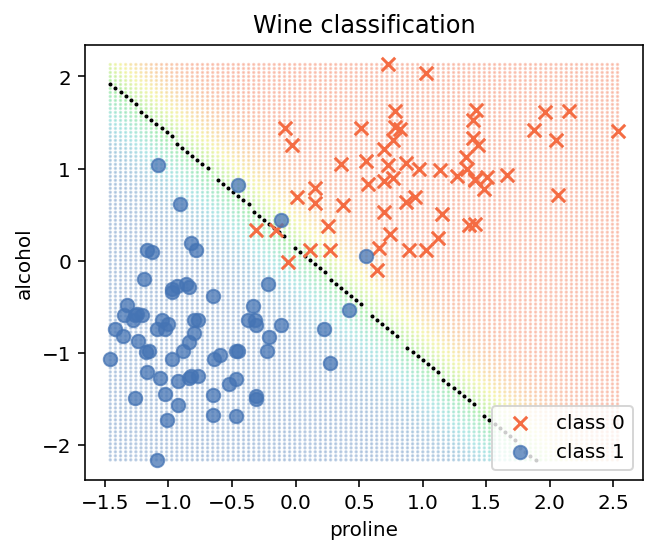

In [288]:
model = nn.Sequential(
    nn.Linear(2, 1), # 2 input vars: proline, alcohol
    nn.Sigmoid(),
)
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=15_000)

dshow(X, y, model, boundary_tolerance=.02)

Epoch     0 cross entropy loss  0.7104
Epoch  1500 cross entropy loss  0.1057
Epoch  3000 cross entropy loss  0.0828
Epoch  4500 cross entropy loss  0.0741
Epoch  6000 cross entropy loss  0.0595
Epoch  7500 cross entropy loss  0.0505
Epoch  9000 cross entropy loss  0.0449
Epoch 10500 cross entropy loss  0.0416
Epoch 12000 cross entropy loss  0.0397
Epoch 13500 cross entropy loss  0.0384
Epoch 15000 cross entropy loss  0.0375
LAST        cross entropy loss  0.0375


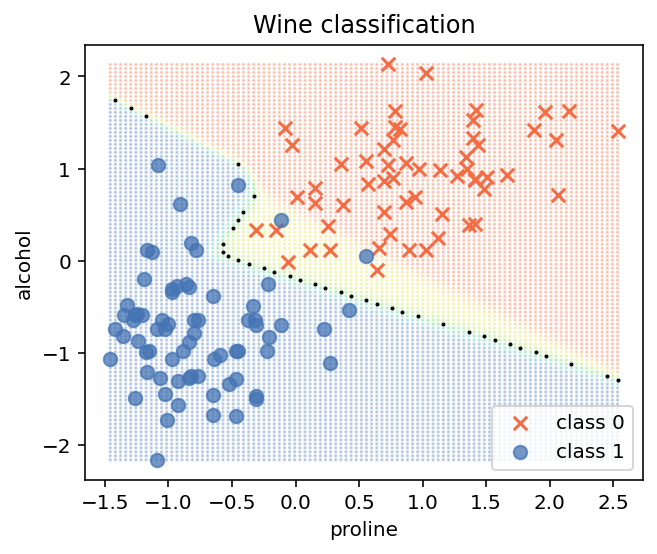

In [299]:
model = nn.Sequential(
    nn.Linear(2, 3), # 2 input vars: proline, alcohol
    nn.Tanh(),
    nn.Linear(3, 1),
    nn.Sigmoid()
)
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=15_000)

dshow(X, y, model)

Epoch     0 cross entropy loss  0.8135
Epoch  1500 cross entropy loss  0.0823
Epoch  3000 cross entropy loss  0.0742
Epoch  4500 cross entropy loss  0.0632
Epoch  6000 cross entropy loss  0.0535
Epoch  7500 cross entropy loss  0.0453
Epoch  9000 cross entropy loss  0.0337
Epoch 10500 cross entropy loss  0.0175
Epoch 12000 cross entropy loss  0.0069
Epoch 13500 cross entropy loss  0.0026
Epoch 15000 cross entropy loss  0.0010
LAST        cross entropy loss  0.0010


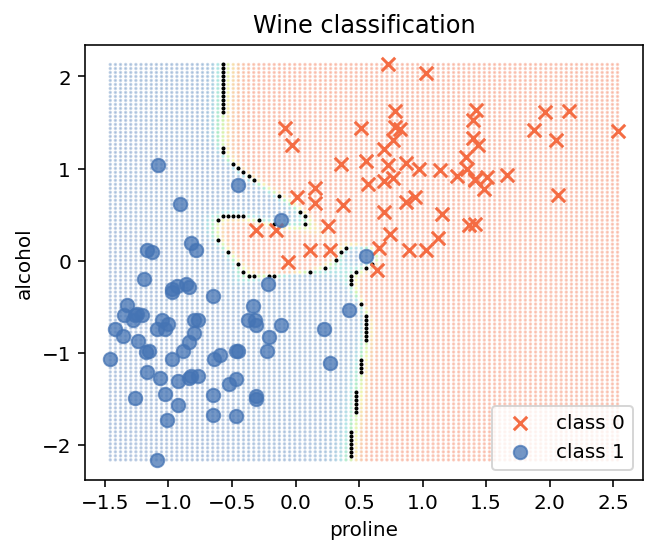

In [300]:
model = nn.Sequential(
    nn.Linear(2, 10), # 2 input vars: proline, alcohol
    nn.Tanh(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=15_000)

dshow(X, y, model, boundary_tolerance=.1)

Epoch     0 cross entropy loss  0.6807
Epoch  1500 cross entropy loss  0.0499
Epoch  3000 cross entropy loss  0.0271
Epoch  4500 cross entropy loss  0.0197
Epoch  6000 cross entropy loss  0.0039
Epoch  7500 cross entropy loss  0.0002
Epoch  9000 cross entropy loss  0.0000
Epoch 10500 cross entropy loss  0.0000
Epoch 12000 cross entropy loss  0.0000
Epoch 13500 cross entropy loss  0.0000
Epoch 15000 cross entropy loss  0.0000
LAST        cross entropy loss  0.0000


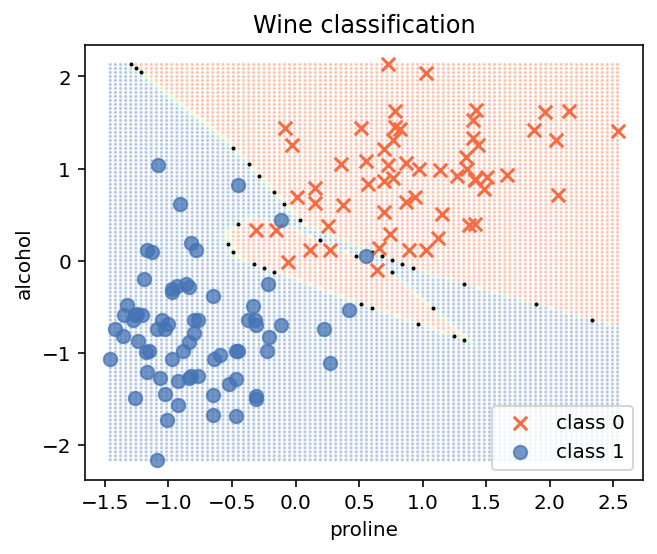

In [296]:
model = nn.Sequential(
    nn.Linear(2, 10), # 2 input vars: proline, alcohol
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)
X = df[['proline','alcohol']].values
y = df['class'].values
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)
X_ = torch.tensor(X).float()
y_ = torch.tensor(y).reshape(-1,1).float()
y_pred, loss = ctrain(model, X=X_, y=y_, learning_rate = .001, nepochs=15_000)

dshow(X, y, model, boundary_tolerance=.1)